In [36]:
!pip install bartpy

In [37]:
from cause_ml.parameters import build_parameters_from_metric_levels
from cause_ml.constants import Constants
from cause_ml.data_generation import DataGeneratingProcessWrapper
import cause_ml.data_sources as data_sources
from cause_ml.utilities import extract_treat_and_control_data

In [38]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [45]:
import torch
import torch.utils.data as utils
import torch.nn as nn
from torch.autograd import Variable

In [41]:
def build_mlp():
    return MLPRegressor(
        hidden_layer_sizes=(50, 25, 10),
        activation='relu',
        solver='adam',
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=1000,
        shuffle=True,
        random_state=1,
        tol=0.0001,
        verbose=False,
        warm_start=False,
        early_stopping=True,
        validation_fraction=0.10,
        epsilon=1e-08,
        n_iter_no_change=5)

In [46]:
class PytorchMLP():
    BATCH_SIZE=2000
    LEARNING_RATE=0.001
    NUM_EPOCHS=5
    
    class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = nn.Linear(20, 50) 
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(50, 25) 
            self.relu2 = nn.ReLU()
            self.fc3 = nn.Linear(25, 10)  
            self.relu3 = nn.ReLU()
            self.fc4 = nn.Linear(10, 1)  
        
        def forward(self, x):
            out = self.fc1(x)
            out = self.relu1(out)
            out = self.fc2(x)
            out = self.relu2(out)
            out = self.fc3(x)
            out = self.relu3(out)
            out = self.fc4(x)
            return out  
    
    def __init__(self):
        pass
    
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
        
    def fit(X, y):
        tX = torch.Tensor(X)
        ty = torch.Tensor(y)
        dataset = utils.TensorDataset(tX, ty)
        dataloader = utils.DataLoader(dataset,
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True)
        
        net = Net(input_size, hidden_size, num_classes)
    
        # Loss and Optimizer
        criterion = nn.MSELoss()  
        optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)  

        # Train the Model
        for epoch in range(NUM_EPOCHS):
            for i, (X_data, y_val) in enumerate(train_loader):  
                # Convert torch tensor to Variable
                X_var = Variable(X_data)
                y_var = Variable(y_val)

                # Forward + Backward + Optimize
                optimizer.zero_grad()  # zero the gradient buffer
                outputs = net(X_var)
                loss = criterion(outputs, y_var)
                loss.backward()
                optimizer.step()

                if (i+1) % 100 == 0:
                    print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                           %(epoch+1, NUM_EPOCHS, i+1, len(dataset)//BATCH_SIZE, loss.item()))
        
    def predict(X):
        pass
        
def build_pyrotch_mlp():
    pass

In [ ]:
PARTIAL_CORRELATION_DEG = 0.1
def generate_synthetic_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)
    covar_data = covar_data_source.original_covariate_data.to_numpy()
    outcome_coeffs = np.random.uniform(-5, 5, size=20)
    
    noise = np.random.normal(size=n_observations)
    Y0 = (covar_data @ outcome_coeffs) + \
        5*((covar_data[:, 0] > 0.5).astype(int)) + \
        noise
    Y1 = Y0 + 8*((covar_data[:, 1] > 0.1).astype(int))
    
    TE = Y1 - Y0
    T = (np.random.uniform(0, 1, size=n_observations) < prop_score).astype(int)
    Y = T*Y1 + (1-T)*Y0
    
    obs_data = covar_data_source.original_covariate_data.copy()
    obs_data["T"] = T
    obs_data["Y"] = Y
    
    oracle_data = pd.DataFrame({
        "TE": TE,
        "NOISE(Y)": noise,
        "Y0": Y0,
        "Y1": Y1,
        "P(T|X)": prop_score
    })
    
    return obs_data, oracle_data

In [ ]:
def generate_hybrid_data(
    prop_score=0.5,
    n_covars=20,
    n_observations=50000):
    
    covar_data_source = data_sources.load_random_normal_covariates(
        n_covars=n_covars,
        n_observations=n_observations,
        partial_correlation_degree=PARTIAL_CORRELATION_DEG)

    dgp_params = build_parameters_from_metric_levels({
        Constants.MetricNames.TREATMENT_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.OUTCOME_NONLINEARITY: Constants.MetricLevels.LOW,
        Constants.MetricNames.TE_HETEROGENEITY: Constants.MetricLevels.LOW
    })
    
    dgp_params.set_parameter("MIN_PROPENSITY_SCORE", 0.001)
    dgp_params.set_parameter("MAX_PROPENSITY_SCORE", 0.9999)
    dgp_params.set_parameter("TREATMENT_EFFECT_HETEROGENEITY", 0.05)
    dgp_params.set_parameter("OUTCOME_NOISE_TAIL_THICKNESS", 300)
    dgp_params.set_parameter("TARGET_PROPENSITY_SCORE", prop_score)
    dgp_params.set_parameter("TREAT_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 1,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })
    dgp_params.set_parameter("OUTCOME_MECHANISM_COVARIATE_SELECTION_PROBABILITY",
                             {
                                "LINEAR": 1,
                                "POLY_QUAD": 0.0,
                                "POLY_CUBIC": 0.0,
                                "STEP_JUMP": 0.05,
                                "STEP_KINK": 0,
                                "INTERACTION_TWO_WAY": 0,
                                "INTERACTION_THREE_WAY": 0
                             })

    dgp_wrapper = DataGeneratingProcessWrapper(
        parameters=dgp_params, data_source=covar_data_source)

    dgp_wrapper.sample_dgp()

    _ = dgp_wrapper.generate_data()
    
    obs_data = dgp_wrapper.get_observed_data()
    oracle_data = dgp_wrapper.get_oracle_data()
    
    return obs_data, oracle_data

In [ ]:
observed_data, unobservable_data = generate_hybrid_data(prop_score=0.01)
observed_data, unobservable_data = generate_synthetic_data(prop_score=0.01)
observed_data.head()

In [ ]:
unobservable_data.head()

In [ ]:
def score_ITE(ITE_true, ITE_pred):
    return mse(ITE_true, ITE_pred)

In [ ]:
def T_learner(data):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    
    # train u1
    u1 = build_mlp()
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    u1.fit(X_treated, treated_data["Y"])
    
    # train u0
    u0 = build_mlp()
    X_control = control_data.drop(["T", "Y"], axis=1)
    u0.fit(X_control, control_data["Y"])
    
    # Generate potential outcome predictions
    X = data.drop(["T", "Y"], axis=1)
    y_1_predicted = u1.predict(X)
    y_0_predicted = u0.predict(X)
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return ITE_pred, u1, u0

In [ ]:
def S_learner(data):
    # train u1
    u = build_mlp()
    X = data.drop("Y", axis=1)
    u.fit(X, data["Y"])
    
    # Generate potential outcomes
    X_under_treatment = X.copy()
    X_under_treatment["T"] = 1
    
    X_under_control = X.copy()
    X_under_control["T"] = 0
    
    y_1_predicted = u.predict(X_under_treatment)
    y_0_predicted = u.predict(X_under_control)
    y_1_predicted - y_0_predicted
    
    ITE_pred = y_1_predicted - y_0_predicted
    
    return  ITE_pred

In [ ]:
def X_learner(data, prop_score, u1=None, u0=None):
    treated_data, control_data = extract_treat_and_control_data(
        data, data["T"])
    X_treated = treated_data.drop(["T", "Y"], axis=1)
    X_control = control_data.drop(["T", "Y"], axis=1)

    if u1 is None:
        # train u1
        u1 = build_mlp()
        u1.fit(X_treated, treated_data["Y"])
    
    if u0 is None:
        # train u0
        u0 = build_mlp()
        u0.fit(X_control, control_data["Y"])
    
    # Find individual treatment effects for treated/controls
    itet = treated_data["Y"] - u0.predict(X_treated)
    itec =  u1.predict(X_control) - control_data["Y"]
    
    # Fit models to the treated and controls
    te1 = build_mlp()
    te1.fit(X_treated, itet)
    
    te0 = build_mlp()
    te0.fit(X_control, itec)
    
    X = data.drop(["T", "Y"], axis=1)
    te1_predicted = te1.predict(X)
    te0_predicted = te0.predict(X)
    
    # Estimate prop scores
#     lm = LogisticRegression(solver="lbfgs")
#     lm.fit(X, data["T"])
#     prop_scores = lm.predict(X)
    
    # Down-weight observes which are likely to belong
    # to other class.
    te = prop_score*te0_predicted + (1-prop_score)*te1_predicted
    
    return te

In [ ]:
ITE_pred, u1, u0 = T_learner(observed_data)
score_ITE(unobservable_data["TE"], ITE_pred)

In [ ]:
ITE_pred = S_learner(observed_data)
score_ITE(unobservable_data["TE"], ITE_pred)

In [ ]:
ITE_pred = X_learner(observed_data, 0.01, u1, u0)
score_ITE(unobservable_data["TE"], ITE_pred)

In [ ]:
def run_trial(prop_score=0.5, n_covars=20, n_observations=50000):
    observed_data, unobservable_data = generate_synthetic_data(
        prop_score=prop_score,
        n_covars=n_covars,
        n_observations=n_observations)
    
    ITE_true = unobservable_data["TE"]
    
    # T learner
    ITE_pred, u1, u0 = T_learner(observed_data)
    T_loss = score_ITE(ITE_true, ITE_pred)
    
    # S learner
    ITE_pred = S_learner(observed_data)
    S_loss = score_ITE(ITE_true, ITE_pred)
    
    # X learner
    ITE_pred = X_learner(observed_data, prop_score, u1, u0)
    X_loss = score_ITE(ITE_true, ITE_pred)
    
    return T_loss, S_loss, X_loss

In [50]:
N_obs = np.logspace(3.75, 5, 7).astype(int)
# N_obs = [300000, 400000, 500000]
N_obs

array([  5623,   9085,  14677,  23713,  38311,  61896, 100000])

In [51]:
%%time

results = []
N_trials = 10
for n_obs in N_obs:
    print("\nRunning at n:", n_obs, end=": ")
    trial_results = []
    for i in range(N_trials):
        print(i, end=",")
        res = run_trial(prop_score=0.1, n_observations=n_obs)
        trial_results.append(res)
        
    
    trial_results = np.array(trial_results)
    results.append(np.mean(trial_results, axis=0))


Running at n: 5623: 0,1,2,3,4,5,6,7,8,9,
Running at n: 9085: 0,1,2,3,4,5,6,7,8,9,
Running at n: 14677: 0,1,2,3,4,5,6,7,8,9,
Running at n: 23713: 0,1,2,3,4,5,6,7,8,9,
Running at n: 38311: 0,1,2,3,4,5,6,7,8,9,
Running at n: 61896: 0,1,2,3,4,5,6,7,8,9,
Running at n: 100000: 0,1,2,3,4,5,6,7,8,9,CPU times: user 46min 6s, sys: 26min 42s, total: 1h 12min 49s
Wall time: 26min 27s


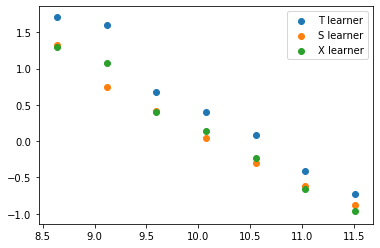

In [53]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
for i, name in enumerate(names):
    plt.scatter(np.log(N_obs), np.log(results[:, i]), label=name)

plt.legend()
plt.show()

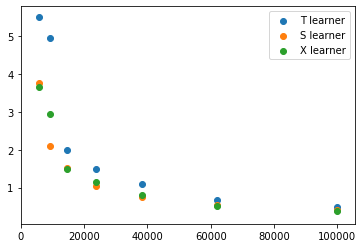

In [54]:
results = np.array(results)
names = ["T learner", "S learner", "X learner"]
for i, name in enumerate(names):
    plt.scatter(N_obs, results[:, i], label=name)

plt.legend()
plt.show()